# Machine Learning pour la Prediction de la temperature 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df

13574144/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [3]:
df["Date Time"] = pd.to_datetime(df['Date Time'], errors='coerce')

## Série chronologique des données climatiques

Nous utiliserons l'ensemble de données climatiques de Jena enregistré par l'Institut Max Planck de biogéochimie. L'ensemble de données est compose de 14 variables telles que la température, la pression, l'humidité, etc., enregistrées une fois toutes les 10 minutes.

Lieu: Station météo, Institut Max Planck de biogéochimie à Jena, Allemagne

Période considérée: du 10 janvier 2009 au 31 décembre 2016

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Visialisation des donnees

Pour donner une idée des données avec lesquelles nous travaillons, chaque variable  est representer ci-dessous.
Cela montre les corrélation entre  la variable  réponse et les differentre variables explicatives au cours de la période allant de 2009 à 2016.
Il permettre  également de detecter les  anomalies aux niveau des données, qui seront corrigées lors de la normalisation.

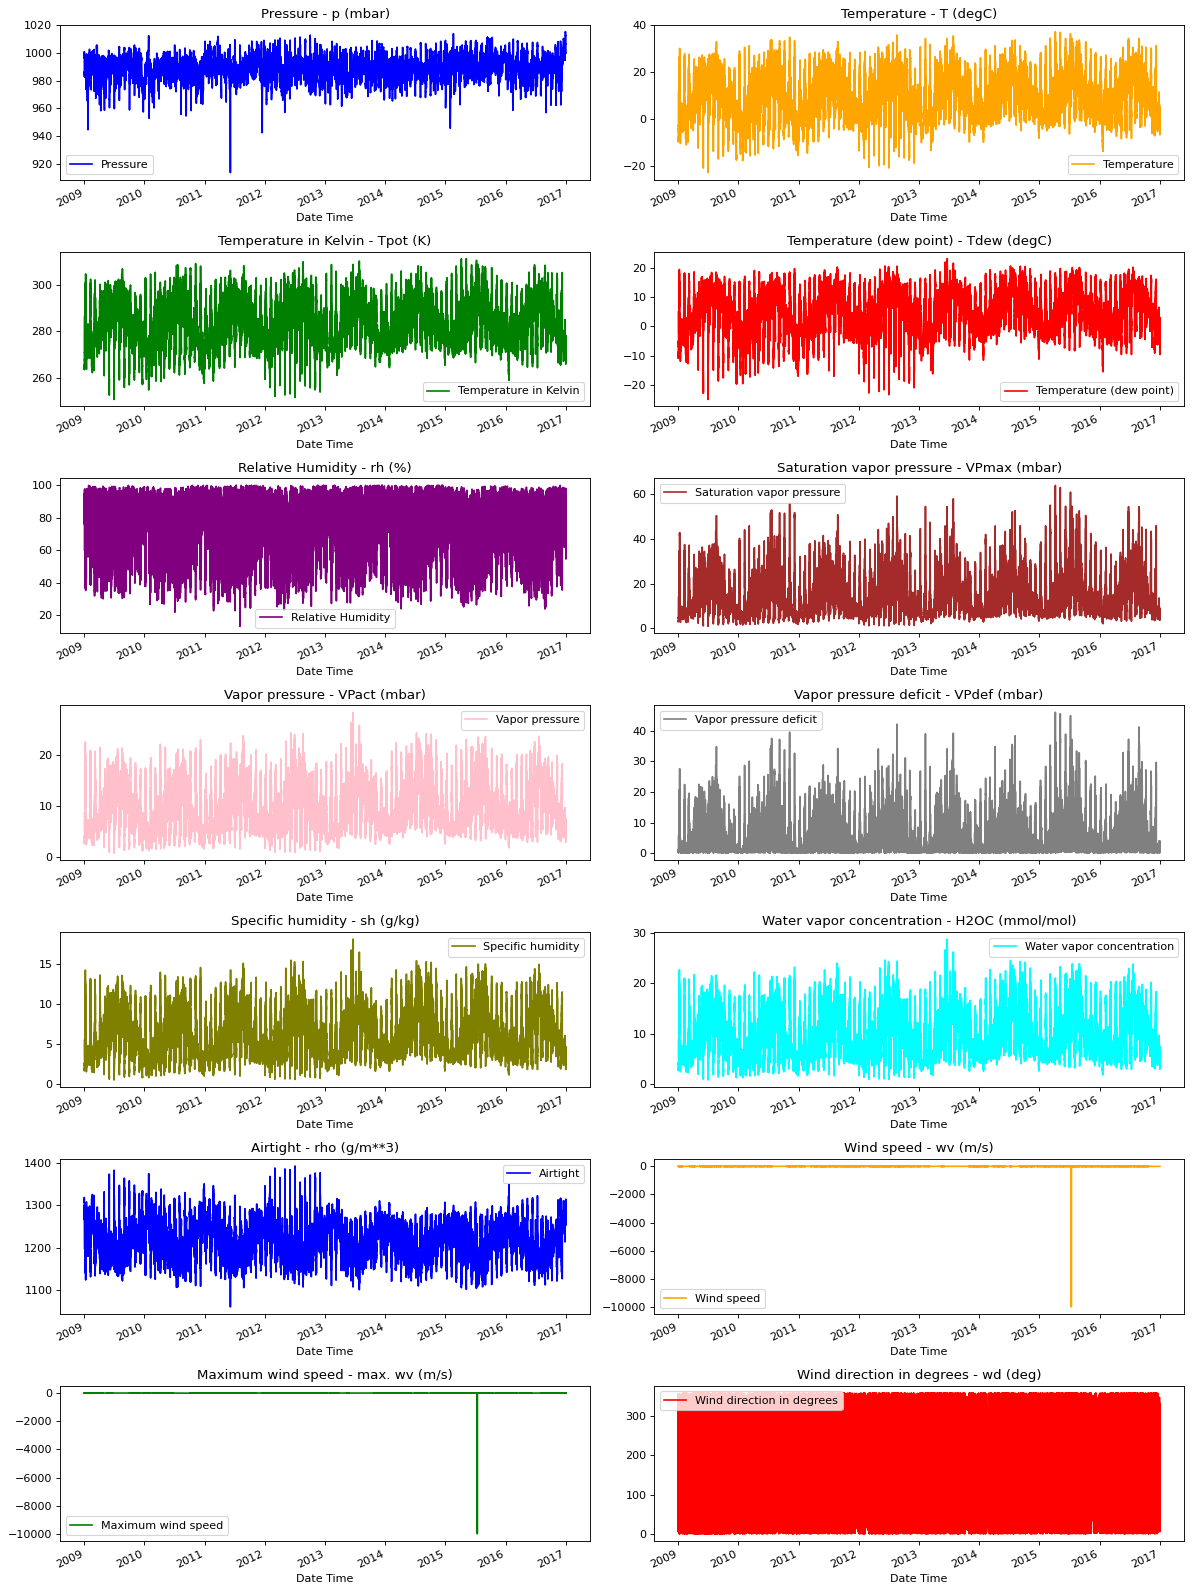

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

Cette graphe represente la correlation entre les differentes variables

<Figure size 1080x720 with 0 Axes>

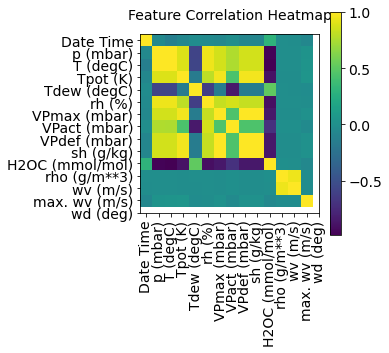

In [6]:
from matplotlib.pyplot import figure


def show_heatmap(data):
    figure(figsize=(15, 10))
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


#Linear Regression prediction

In [7]:
df_corr = df.corr()[["T (degC)"]].sort_values('T (degC)')
df_corr

,T (degC)
rho (g/m**3),-0.963410
rh (%),-0.572416
p (mbar),-0.045375
wv (m/s),-0.004689
max. wv (m/s),-0.002871
wd (deg),0.038732
VPdef (mbar),0.761744
sh (g/kg),0.866755
H2OC (mmol/mol),0.867177
VPact (mbar),0.867673


In [8]:
df_corr_fil = df_corr[abs(df_corr['T (degC)']) > 0.55]
df_corr_fil


,T (degC)
rho (g/m**3),-0.963410
rh (%),-0.572416
VPdef (mbar),0.761744
sh (g/kg),0.866755
H2OC (mmol/mol),0.867177
VPact (mbar),0.867673
Tdew (degC),0.895708
VPmax (mbar),0.951113
Tpot (K),0.996827
T (degC),1.000000


In [9]:
unwanted = ["T (degC)"]
predictors = df_corr_fil.index.tolist()
predictors = [i for i in predictors if i not in unwanted]
predictors

['rho (g/m**3)',
 'rh (%)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'VPact (mbar)',
 'Tdew (degC)',
 'VPmax (mbar)',
 'Tpot (K)']

In [10]:
df2 = df[["T (degC)"] + predictors]
df2.head()

,T (degC),rho (g/m**3),rh (%),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),VPact (mbar),Tdew (degC),VPmax (mbar),Tpot (K)
0,-8.02,1307.75,93.3,0.22,1.94,3.12,3.11,-8.90,3.33,265.40
1,-8.41,1309.80,93.4,0.21,1.89,3.03,3.02,-9.28,3.23,265.01
2,-8.51,1310.24,93.9,0.20,1.88,3.02,3.01,-9.31,3.21,264.91
3,-8.31,1309.19,94.2,0.19,1.92,3.08,3.07,-9.07,3.26,265.12
4,-8.27,1309.00,94.1,0.19,1.92,3.09,3.08,-9.04,3.27,265.15


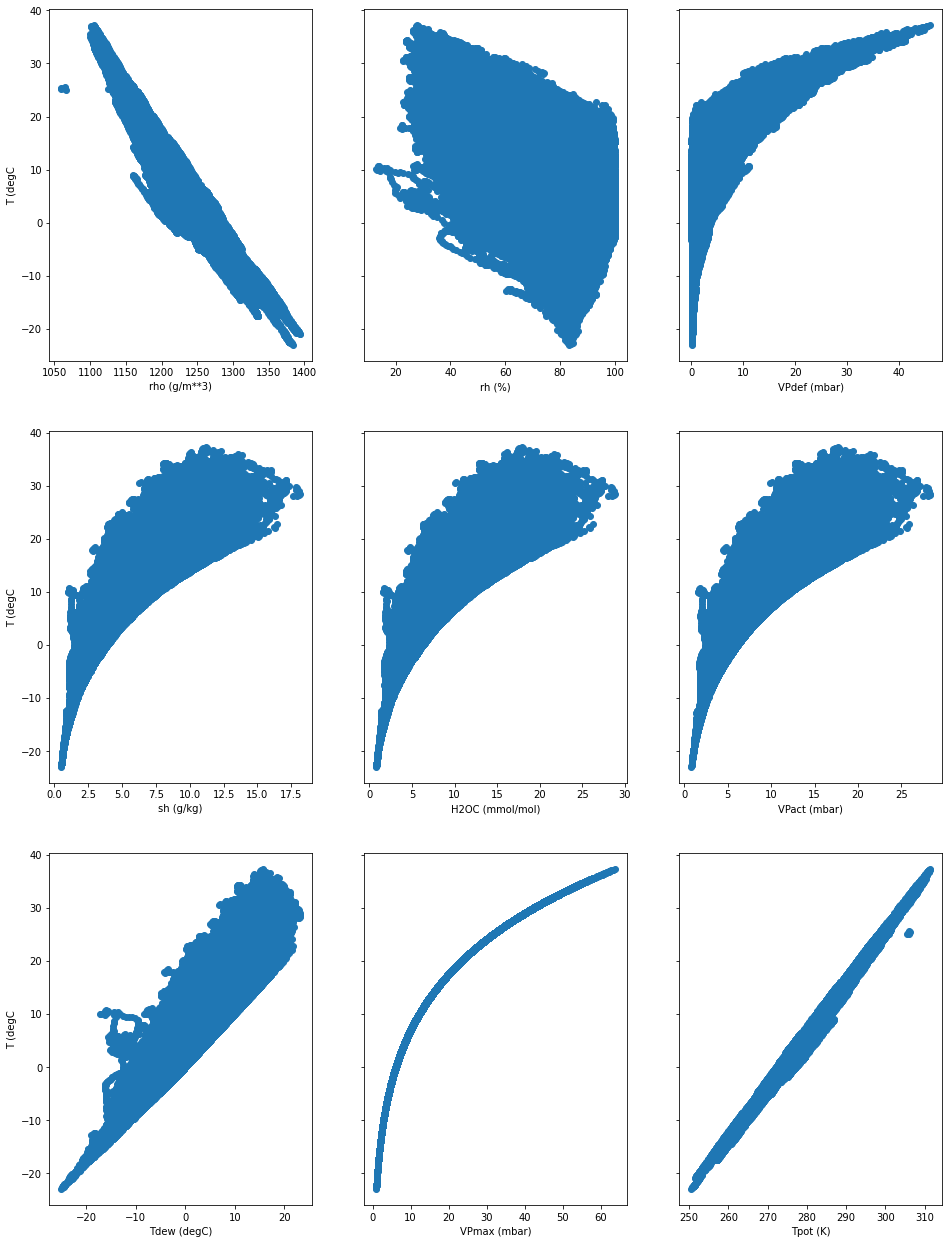

In [11]:
# définir manuellement les paramètres de la figure à une taille appropriée
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that
# the y axes should be shared
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True)


arr = np.array(predictors).reshape(3, 3)


for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2["T (degC)"])
        if col ==0:
            axes[row, col].set(xlabel=feature, ylabel='T (degC')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [12]:
# separarer  les  variables predictives (X) et la variable de reponse (y)
X = df2[predictors]
y = df2["T (degC)"]

# Ajouter un biais B0 au niveau des variables predictives
#X = sm.add_constant(X)
X.iloc[:5, :5]
X

,rho (g/m**3),rh (%),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),VPact (mbar),Tdew (degC),VPmax (mbar),Tpot (K)
0,1307.75,93.30,0.22,1.94,3.12,3.11,-8.90,3.33,265.40
1,1309.80,93.40,0.21,1.89,3.03,3.02,-9.28,3.23,265.01
2,1310.24,93.90,0.20,1.88,3.02,3.01,-9.31,3.21,264.91
3,1309.19,94.20,0.19,1.92,3.08,3.07,-9.07,3.26,265.12
4,1309.00,94.10,0.19,1.92,3.09,3.08,-9.04,3.27,265.15
...,...,...,...,...,...,...,...,...,...
420546,1292.98,73.10,1.22,2.06,3.30,3.30,-8.13,4.52,269.10
420547,1289.44,69.71,1.44,2.07,3.32,3.32,-8.06,4.77,269.81
420548,1288.39,67.91,1.55,2.05,3.28,3.28,-8.21,4.84,270.01
420549,1293.56,71.80,1.26,1.99,3.20,3.20,-8.53,4.46,268.94


In [13]:
alpha = 0.01

def stepwise_selection(X, y, 
                       initial_list=predictors,  
                       threshold_out=alpha, 
                       verbose=True):
   
    included = list(initial_list)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # Si le p-value est null
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

resulting features:
['rho (g/m**3)', 'rh (%)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'VPact (mbar)', 'Tdew (degC)', 'VPmax (mbar)', 'Tpot (K)']


In [14]:
X = X[result]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               T (degC)   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.210e+07
Date:                Sun, 02 May 2021   Prob (F-statistic):                        0.00
Time:                        04:20:40   Log-Likelihood:                     -1.2038e+05
No. Observations:              420551   AIC:                                  2.408e+05
Df Residuals:                  420542   BIC:                                  2.409e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
rho (g/m**3)       -0.0257   7.95e-05   -323.899      0.000      -0.026      -0.026
rh (%)             -0.1184      0.000   -913.007      0.000      -0.119      -0.118
VPdef (mbar)       -1.5060      0.099    -15.188      0.000      -1.700      -1.312
sh (g/kg)          -1.5388      0.124    -12.415      0.000      -1.782      -1.296
H2OC (mmol/mol)    -3.8902      0.079    -49.456      0.000      -4.044      -3.736
VPact (mbar)        3.1662      0.100     31.796      0.000       2.971       3.361
Tdew (degC)         0.7198      0.001    768.635      0.000       0.718       0.722
VPmax (mbar)        1.7049      0.099     17.195      0.000       1.511       1.899
Tpot (K)            0.1613      0.000    504.986      0.000       0.161       0.162
==============================================================================
Omnibus:                   234009.454   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6303714.126
Skew:                           2.164   Prob(JB):                         0.00
Kurtosis:                      21.466   Cond. No.                     4.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

In [52]:
# instancier la classe de LinearRegression()

model = LinearRegression()

# adapter le modèle en adaptant le régresseur aux données d'entraînement 
model.fit(X_train, y_train)

# Faire la prediction sur les donnees tests
prediction = model.predict(X_test)

# Evaluer la prediction  en termes d'accuracy du  model 
print('The Explained Variance: %.2f' % regressor.score(X_test, y_test))
print('The Mean Absolute Error: %.2f degrees celcius' % mean_absolute_error(
    y_test, prediction))
print('The Median Absolute Error: %.2f degrees celcius' %
      median_absolute_error(y_test, prediction))

The Explained Variance: 1.00
The Mean Absolute Error: 0.02 degrees celcius
The Median Absolute Error: 0.02 degrees celcius


,rho (g/m**3),rh (%),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),VPact (mbar),Tdew (degC),VPmax (mbar),Tpot (K)
206829,1258.71,72.00,1.43,2.34,3.76,3.68,-6.75,5.11,272.34
167829,1232.37,61.50,4.81,4.77,7.64,7.68,3.19,12.49,282.96
218495,1260.82,99.30,0.04,3.80,6.09,6.04,-0.16,6.08,273.83
59384,1272.61,69.65,1.08,1.58,2.54,2.47,-11.79,3.54,268.07
359713,1260.40,97.40,0.20,4.66,7.47,7.49,2.83,7.69,276.14
...,...,...,...,...,...,...,...,...,...
132490,1196.94,85.30,2.25,8.24,13.19,13.05,10.89,15.30,287.35
300671,1163.41,63.74,8.86,9.87,15.78,15.58,13.58,24.44,294.93
133281,1180.65,51.32,9.55,6.36,10.19,10.07,7.06,19.62,291.35
352243,1201.74,78.10,3.36,7.54,12.06,11.98,9.61,15.34,287.09


In [45]:
X_test_new = X_test.head(1)
X_test_new

,rho (g/m**3),rh (%),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),VPact (mbar),Tdew (degC),VPmax (mbar),Tpot (K)
206829,1258.71,72.0,1.43,2.34,3.76,3.68,-6.75,5.11,272.34


In [46]:
regressor.predict(X_test_new)

array([-2.4602475])

#Save Model Linear

In [19]:
import pickle as pk

In [54]:
import joblib as jb
jb.dump(model, "model_linear.ml")

['model_linear.ml']

In [55]:
Ml = jb.load("model_linear.ml")

In [56]:
Ml.predict(X_test_new)[0]

-2.460247499508398

#LSTM Model

## Data Preprocessing

Ici, nous sélectionnons environ 300 000 points de données pour la formation. L'observation est enregistrée chaque
10 minutes, cela signifie 6 fois par heure. Nous rééchantillonnerons un point par heure car non
un changement radical est attendu dans les 60 minutes. Nous faisons cela via le `taux_échantillonnage`
argument dans l'utilitaire `timeseries_dataset_from_array`.

Nous suivons les données des 720 derniers horodatages (720/6 = 120 heures). Ces données seront
utilisé pour prédire la température après 72 horodatages (72/6 = 12 heures).

Puisque chaque fonctionnalité a des valeurs avec
différentes plages, nous effectuons une normalisation pour limiter les valeurs des caractéristiques à une plage de «[0, 1]» avant
formation d'un réseau de neurones.
Nous faisons cela en soustrayant la moyenne et en divisant par l'écart type de chaque caractéristique.

71,5% des données seront utilisées pour entraîner le modèle, soit 300693 lignes. `split_fraction` peut
être modifié pour modifier ce pourcentage.

Le modèle affiche les données des 5 premiers jours, c'est-à-dire 720 observations, qui sont échantillonnées tous les
heure. La température après 72 (12 heures * 6 observations par heure) d'observation sera
utilisé comme étiquette.

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [ ]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


## Training

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


Nous utiliserons le rappel `ModelCheckpoint` pour enregistrer régulièrement les points de contrôle, et
le callback `EarlyStopping` pour interrompre l'entraînement lorsque la validation est perdue
ne s’améliore plus. 

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - 176s 149ms/step - loss: 0.2964 - val_loss: 0.1443

Epoch 00001: val_loss improved from inf to 0.14433, saving model to model_checkpoint.h5
Epoch 2/10
1172/1172 [==============================] - 176s 150ms/step - loss: 0.1357 - val_loss: 0.1420

Epoch 00002: val_loss improved from 0.14433 to 0.14202, saving model to model_checkpoint.h5
Epoch 3/10
1172/1172 [==============================] - 177s 151ms/step - loss: 0.1222 - val_loss: 0.1473

Epoch 00003: val_loss did not improve from 0.14202
Epoch 4/10
1172/1172 [==============================] - 174s 149ms/step - loss: 0.1189 - val_loss: 0.1430

Epoch 00004: val_loss did not improve from 0.14202
Epoch 5/10
1172/1172 [==============================] - 173s 147ms/step - loss: 0.1176 - val_loss: 0.1405

Epoch 00005: val_loss improved from 0.14202 to 0.14053, saving model to model_checkpoint.h5
Epoch 6/10
1172/1172 [==============================] - 174s 149ms/step - loss: 0.1139 - va

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

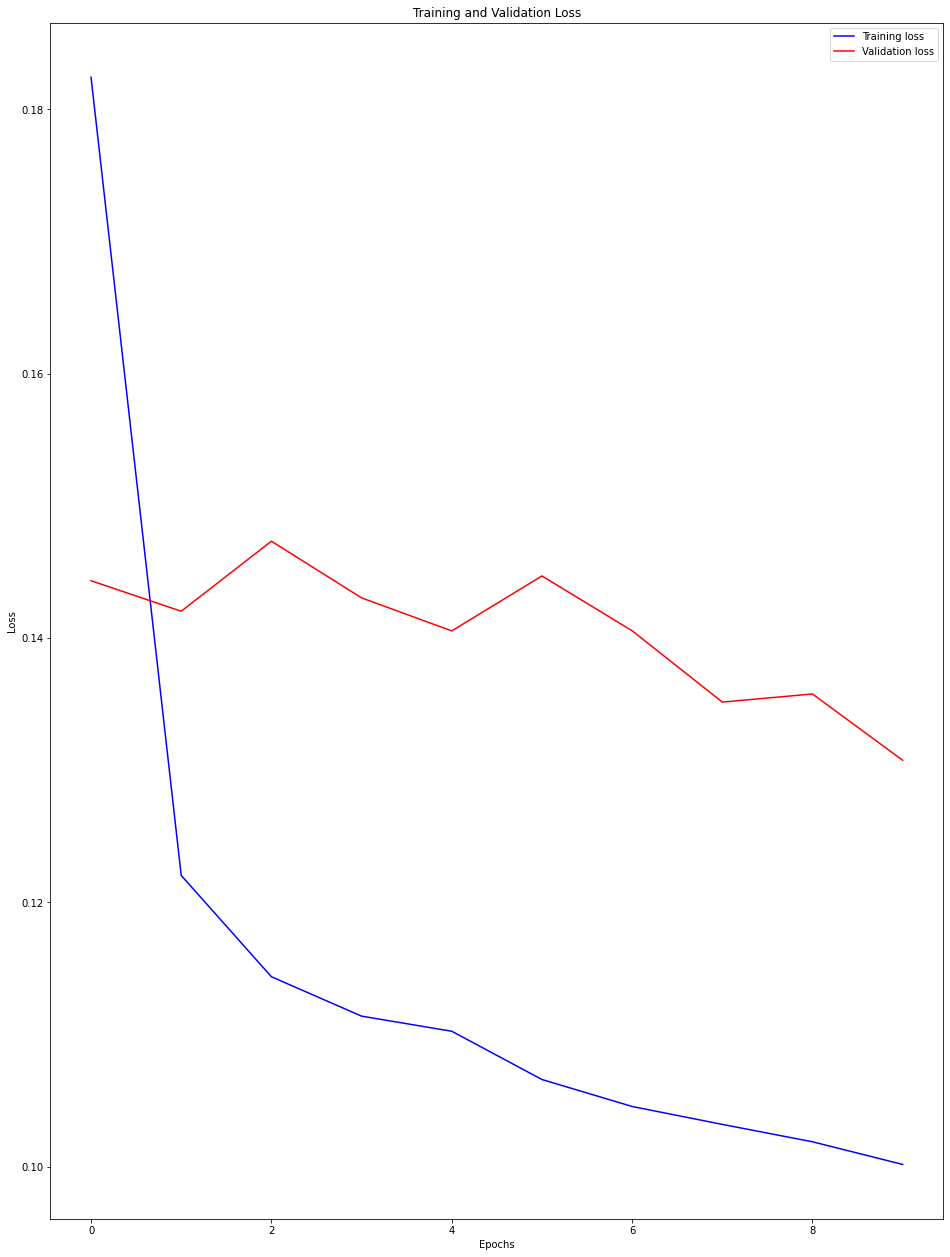

In [ ]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction
Le modèle entrainner  ci-dessus est maintenant capable de faire des prédictions pour 5 ensembles de valeurs à partir de donnees de validation. 


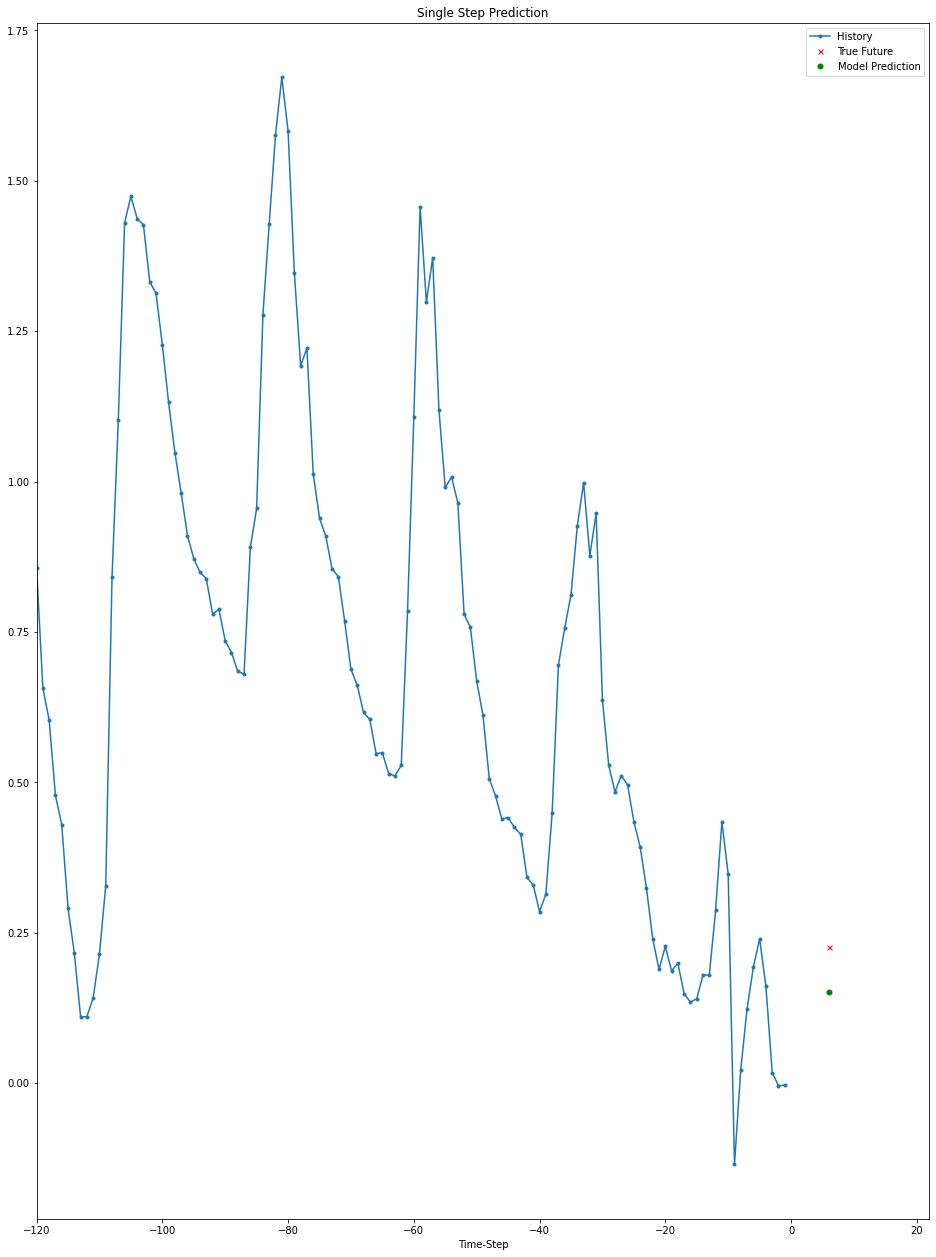

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        6,
        "Single Step Prediction",
    )